### Simple Exaplanatory Data Analysis on Timeseries Stock Market Data

Feature engineering

In [ ]:
import numpy as np
import pandas as pd

def daily_return(df: pd.DataFrame):
    df['Daily_returns'] = df['Close'].pct_change(1).fillna(0)
    return df

### MOMENTUM INDICATORS ###
def roc_indicator(df: pd.DataFrame):
    # Computes rate of change (RoC), i.e momentum - percent change
    df["RoC"] = df['Close'].diff() / df['Close'][:-1]
    return df

def williams_r(df: pd.DataFrame, lookback: int):
    # Computes Williams %R that measures overbought and oversold levels
    wr = np.zeros(len(df))
    for t_idx in range(len(df)):
        if t_idx + 1 <= lookback:
            wr[t_idx] = 0
        else:
            highest = np.max(df['High'][t_idx-lookback:t_idx].values)
            lowest = np.min(df['Low'][t_idx-lookback:t_idx].values)
            wr[t_idx] = (highest - df['Close'][t_idx]) / (highest - lowest)
    df["williams_r"] = wr
    return df

### VOLUME INDICATORS ###
def money_flow_index(df: pd.DataFrame, period: int):
    # Measures buying and selling pressure (if below 20 then buy if above 80 then sell)
    typical_price = (df['Close'] + df['High'] + df['Low']) / 3
    money_flow = typical_price * df['Volume']
    positive_flow, negative_flow = [], []
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]:
            positive_flow.append(money_flow[i-1])
            negative_flow.append(0)
        elif typical_price[i] < typical_price[i-1]:
            positive_flow.append(0)
            negative_flow.append(money_flow[i-1])
        else:
            positive_flow.append(0)
            negative_flow.append(0)

    positive_mf = [sum(positive_flow[i + 1 - period:i + 1]) for i in range(period-1, len(positive_flow))]
    negative_mf = [sum(negative_flow[i + 1 - period:i + 1]) for i in range(period - 1, len(negative_flow))]
    idx = 0
    mfi = np.zeros(len(df))
    for t_idx in range(len(df)):
        if t_idx + 1 <= period:
            mfi[t_idx] = 0
        else:
            mfi[t_idx] = 100 * (positive_mf[idx] / (positive_mf[idx] + negative_mf[idx]))
            idx += 1
    df["MFI"] = mfi
    return df

### VOLATILITY INDICATORS ###
def ulcer_index(df: pd.DataFrame, lookback: int):
    # Measures downside risk in terms of depth and duration of price declines
    ui = np.zeros(len(df))
    for t_idx in range(len(df)):
        if t_idx + 1 <= lookback:
            ui[t_idx] = 0
        else:
            maxprice = np.max(df['Close'][t_idx-lookback:t_idx].values)
            percentage_drawdown = [(df['Close'][t_idx-i]-maxprice)/maxprice * 100 for i in reversed(range(lookback))]
            ulcer_ind = np.sqrt(np.sum(np.array(percentage_drawdown)**2) / lookback)
            ui[t_idx] = ulcer_ind
    df['Ulcer_index'] = ui
    return df

def average_true_range(df: pd.DataFrame, lookback: int):
    # Measures market volatility
    av_tr_rang = np.zeros(len(df))
    for t_idx in range(len(df)):
        if t_idx + 1 <= lookback:
            av_tr_rang[t_idx] = 0
        else:
            true_ranges = []
            for idx in reversed(range(lookback)):
                tr1 = df['High'][t_idx-idx] - df['Low'][t_idx-idx]
                tr2 = np.abs(df['High'][t_idx-idx] - df['Close'][t_idx-idx])
                tr3 = np.abs(df['Low'][t_idx-idx] - df['Close'][t_idx-idx])
                true_ranges.append(np.max([tr1, tr2, tr3]))
            atr = sum(true_ranges) / lookback
            av_tr_rang[t_idx] = atr
    df['ATR'] = av_tr_rang
    return df

### TREND INDICATORS ###

def simple_moving_average(df: pd.DataFrame, windows: list):
    for window in windows:
        df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean().fillna(0)
    return df

def exponential_moving_average(df: pd.DataFrame, windows: list):
    for window in windows:
        df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean().fillna(0)
    return df


def get_indicators(df: pd.DataFrame):
    df = daily_return(df)
    df = roc_indicator(df)
    df = williams_r(df, 14)
    df = money_flow_index(df, 14)
    df = ulcer_index(df, 14)
    df = average_true_range(df, 14)
    df = simple_moving_average(df, [5, 10, 20])
    df = exponential_moving_average(df, [20, 50])
    return df

Exaplanatory Analysis Functions

In [ ]:
# Standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
# sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")
import random

# import indicators

# Collect data from yahoo finance
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime


# Configuration class
class config:
    # Select time length in years, months and days
    yrs = 3
    mths = 0
    dys = 0

    # Starting of with google stocks
    stock_names_compare = ['GOOG', 'AAPL', 'MSFT', 'AMZN']
    stock_names = ['GOOG']

    colors = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)',
              'rgb(44, 160, 44)', 'rgb(214, 39, 40)',
              'rgb(148, 103, 189)', 'rgb(140, 86, 75)',
              'rgb(227, 119, 194)', 'rgb(127, 127, 127)',
              'rgb(188, 189, 34)', 'rgb(23, 190, 207)']


# Start and end times for the time-series
def get_timestamps(yrs=0, mths=0, dys=0):
    '''
        Input:  yrs - number of years back in time to track
                mths - number of months back in time to track
                dys - number of days back in time to track
        Output: start_time and end_time as a list
    '''
    end_time = datetime.now()
    start_time = datetime(end_time.year - yrs, end_time.month - mths, end_time.day - dys)

    return [start_time, end_time]


# Collecting data from yahoo finance to dataframe

def collect_data(timestamps, stock_name, moving_averages=None, include_gain=True, compute_volatility = False):
    '''
        Input: timestamps - start and end time of the time period to track time
               stock_name - code of the stock from the specific company
        Output: Dataframe of the stock for the selected time period
    '''

    locals()[stock_name] = DataReader(stock_name, 'yahoo', timestamps[0], timestamps[1])
    company_stock = [vars()[stock_name]]
    company_stock_name = [stock_name]
    for comp, name in zip(company_stock, company_stock_name):
        comp["Company stock name"] = name

    df_stock = pd.concat(company_stock, axis=0)

    return df_stock


def preprocess_data(df):
    if df.columns[0] == 'Date':
        df = df.set_index('Date')

    df = get_indicators(df)
    return df



# Plot functions
def plot_closing(df, moving_averages=True, intervals=None):
    '''
        Input: df - dataframe of the stock
               intervals - list of ints of time periods to split the dataframe
        Output: Figure of closing price of the stock
    '''

    colors = config.colors
    fig = go.Figure()

    x = [str(df.index[i]).split()[0] for i in range(len(df))]
    fig.add_trace(
        go.Scatter(x=x, y=df['Adj Close'], mode='lines', line_color=colors[0], line_width=3,
                   name='Adjusted Closing Price'))
    i_color = 1
    for c in df.columns:

        if c.endswith('MA'):
            fig.add_trace(go.Scatter(x=x,
                                     y=df[c],
                                     mode='lines',
                                     line_color=colors[i_color],
                                     line_width=2,
                                     name=c))
            i_color += 1

    fig.update_layout(showlegend=True)
    fig.update_layout(title=dict(text=f'"{df["Company stock name"][0]}" stocks from {x[0]} to {x[len(df) - 1]}',
                                 xanchor='auto'),
                      xaxis=go.layout.XAxis(
                          title=go.layout.xaxis.Title(
                              text="Date")),
                      yaxis=go.layout.YAxis(
                          title=go.layout.yaxis.Title(
                              text="Adjusted closing price USD ($)"))
                      )
    return fig


def plot_gain(df):
    '''
        Input: df - Dataframe of the stock
        Output: Histograms of the daily returns and the daily change in percentage of the stock
    '''

    xDR = np.arange(min(df['Daily Return'].dropna().tolist()),
                    max(df['Daily Return'].dropna().tolist()),
                    len(df['Daily Return'].dropna()))
    xC = np.arange(min(df['Change %'].dropna().tolist()),
                   max(df['Change %'].dropna().tolist()),
                   len(df['Change %'].dropna()))

    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=(f'Daily Return of stock "{df["Company stock name"][0]}"',
                                        f'Daily change in % of stock "{df["Company stock name"][0]}"'))

    fig.add_trace(go.Histogram(x=df['Daily Return'].dropna(), marker_color='#330C73', opacity=0.8), row=1, col=1)
    fig.add_trace(go.Scatter(x=xDR, y=df['Daily Return'].dropna(), mode='lines', line_color='#330C73'), row=1, col=1)

    fig.add_trace(go.Histogram(x=df['Change %'].dropna(), marker_color='#330C73', opacity=0.8), row=1, col=2)
    fig.add_trace(go.Scatter(x=xC, y=df['Change %'].dropna(), mode='lines', line_width=5, line_color='#330C73'), row=1,
                  col=2)

    fig.update_layout(showlegend=False)

    fig.update_xaxes(title_text="Price USD ($)", row=1, col=1)
    fig.update_xaxes(title_text="Percentage %", row=1, col=2)

    fig.update_yaxes(title_text="Counts", row=1, col=1)
    fig.update_yaxes(title_text="Counts", row=1, col=2)

    fig.update_layout(
        bargap=0.1,
        bargroupgap=0.1
    )

    return fig


def compare_stocks(dfs, timestamps):
    '''
        Input: dfs - list of dataframes for the different stocks to be compared
               timestamps - list of start and end time of the time period to be analysed
        Output: daily_returns - dataframe of the daily returns of all the stocks
                fig1 - correlation grid of the adjusted closing price of all the stocks
                fig2 - correlation matrix of the daily returns of all the stocks
    '''

    closing = DataReader(dfs, 'yahoo', timestamps[0], timestamps[1])['Adj Close']
    daily_returns = closing.pct_change()
    x = [str(daily_returns.dropna().index[i]).split()[0] for i in range(len(daily_returns.dropna()))]

    fig1 = sns.PairGrid(daily_returns.dropna(), )
    fig1.map_upper(plt.scatter, color='#330C73')

    fig1.map_lower(sns.kdeplot, cmap='RdPu_r')

    fig1.map_diag(plt.hist, bins=30)
    fig1.fig.suptitle(
        f'Graphical correlation between the different stocks for the daily returns from {x[0]} to {x[len(x) - 1]}',
        fontsize=18, y=1.03)

    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    sns.heatmap(closing.corr(), annot=True, cmap='PuBu', ax=ax1)
    sns.heatmap(daily_returns.corr(), annot=True, cmap='PuRd', ax=ax2)

    fig2.suptitle(
        f'Correlation between the different stocks for the closing price and the daily returns from {x[0]} to {x[len(x) - 1]}',
        fontsize=18)
    ax1.set_title('Adjusted Closing Price USD ($)')
    ax2.set_title('Daily returns USD ($)')
    ax1.set_xlabel('')
    ax2.set_xlabel('')
    ax1.set_ylabel('')
    ax2.set_ylabel('')

    return daily_returns, fig1, fig2


In [ ]:
# Standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# sns.set_style('darkgrid')
# plt.style.use('seaborn-darkgrid')


# statistics
import statsmodels.api as sm

# Collect data from yahoo finance
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

# scripts
# import preprocess


class analysis_config:
    lookback_days = -1
    season_period = 365

def get_data(csv):
    if csv:
        df = pd.read_csv(csv)
        df = df.set_index('Date')
        return df
    else:
        timestamps = get_timestamps(config.yrs,config.mths,config.dys)

        df = collect_data(timestamps, config.stock_names[0],
                                     moving_averages=config.moving_averages,
                                    include_gain=True)
        return df

def data_preparation(df):
    # Get inter-daily mean
    df["Mean"] = (df["Low"] + df["High"]) / 2
    # Creating target column of next day price based on 'lookback_days' previous days
    df_new = df.copy()
    df_new["Actual"] = df_new["Mean"].shift(analysis_config.lookback_days).dropna()

    # If date is not index yet
    if df_new.columns[0] == 'Date':
        df_new["Date"] = pd.to_datetime(df_new["Date"])
        df_new.index = df_new["Date"]

    return df_new

def analyse_movement(df):
    # Get the trend, seasonality and noise of the data
    seas_d = sm.tsa.seasonal_decompose(df["Mean"], model="add", period=analysis_config.season_period)
    seas_trend = seas_d.trend.values
    seas_seas = seas_d.seasonal.values
    seas_res = seas_d.resid.values
    seas_obs = seas_d.observed.values
    dates = [str(seas_d.trend.index.values[i]).split('T')[0] for i in range(len(seas_d.trend.index.values))]

    matplotlib.style.use('seaborn-darkgrid')
    fig, axes = plt.subplots(4, 1, figsize=(14, 16))
    first_plot_labels = [item.get_text() for item in axes[0].get_xticklabels()]
    nr_label_indexes = len(dates) // (len(first_plot_labels))
    first_plot_labels_new = [str(dates[0])]
    [first_plot_labels_new.append(dates[i * nr_label_indexes]) for i in range(len(first_plot_labels))]
    first_plot_labels_new.append(dates[-1])
    axes[0].set_xticklabels(first_plot_labels_new)
    axes[0].plot(seas_obs, color='#76C2F7', linewidth=1)
    axes[0].set_title('Observed data')
    axes[0].set_ylabel('USD $')

    second_plot_labels = [item.get_text() for item in axes[1].get_xticklabels()]
    nr_label_indexes = len(dates) // (len(second_plot_labels)-2)
    second_plot_labels_new = [str(dates[0])]
    [second_plot_labels_new.append(dates[i * nr_label_indexes]) for i in range(len(second_plot_labels)-2)]
    second_plot_labels_new.append(dates[-1])
    axes[1].set_xticklabels(second_plot_labels_new)
    axes[1].plot(seas_trend, color='#9876F7', linewidth=1)
    axes[1].set_ylabel('Trend')

    third_plot_labels = [item.get_text() for item in axes[2].get_xticklabels()]
    nr_label_indexes = len(dates) // (len(third_plot_labels))
    third_plot_labels_new = [str(dates[0])]
    [third_plot_labels_new.append(dates[i * nr_label_indexes]) for i in range(len(third_plot_labels))]
    third_plot_labels_new.append(dates[-1])
    axes[2].set_xticklabels(third_plot_labels_new)
    axes[2].plot(seas_seas, color='#F776DF', linewidth=1)
    axes[2].set_ylabel('Seasonality')

    fourth_plot_labels = [item.get_text() for item in axes[3].get_xticklabels()]
    nr_label_indexes = len(dates) // (len(fourth_plot_labels)-2)
    fourth_plot_labels_new = [str(dates[0])]
    [fourth_plot_labels_new.append(dates[i * nr_label_indexes]) for i in range(len(fourth_plot_labels)-2)]
    fourth_plot_labels_new.append(dates[-1])
    axes[3].set_xticklabels(fourth_plot_labels_new)
    axes[3].plot(seas_res, color='#F77676', linewidth=1)
    axes[3].set_ylabel('Random noise')
    # plt.savefig('./demonstration_images/analysis_ex.png')
    plt.show()


def ADFtest(time_series):
    # Augmented Dickey-Fuller test to check if data is stationary
    dfout = {}
    dftest = sm.tsa.adfuller(time_series.dropna(), autolag='AIC', regression='ct')
    for key, val in dftest[4].items():
        dfout[f'critical value ({key})'] = val
    if dftest[1] <= 0.05:
        print(f"Strong evidence against Null Hypothesis, p-value: {dftest[1]:.4f} < 0.05")
        print("Reject Null Hypothesis - Data is Stationary")
        return True
    else:
        print("Strong evidence for Null Hypothesis")
        print(f"Accept Null Hypothesis - Data is not Stationary, p-value: {dftest[1]:.4f} > 0.05")
        return False

def get_stationary_data(df:pd.DataFrame, columns:list, diff:int):
    # Making the data stationary
    df_cp = df.copy()
    for col in columns:
        df_cp[str(col)] = pd.DataFrame(np.log(df_cp[str(col)]).diff().diff(diff))
    return df_cp

def inverse_stationary_data(old_df:pd.DataFrame, new_df_: pd.DataFrame, orig_feature: str,
                            new_feature: str, diff: int, do_orig=True):
    # Inverse the stationary data transformation
    new_df = new_df_.copy()
    if do_orig:
        new_df[orig_feature] += np.log(old_df[orig_feature]).shift(1)
        new_df[orig_feature] += np.log(old_df[orig_feature]).diff().shift(diff)
        new_df[orig_feature] = np.exp(new_df[orig_feature])
    new_df[new_feature] += np.log(old_df[orig_feature]).shift(1)
    new_df[new_feature] += np.log(old_df[orig_feature]).diff().shift(diff)
    new_df[new_feature] = np.exp(new_df[new_feature])
    return new_df

def plot_stationary(df, df_stat):
    matplotlib.style.use('seaborn-darkgrid')
    fig, axes = plt.subplots(1,2,figsize=(20,6))
    axes[0].plot(df['Close'], color='#DC76F7', linewidth=1)
    axes[1].plot(df_stat['Close'], color='#DC76F7', linewidth=1)

    dates = [str(df.index.values[i]).split('T')[0] for i in range(len(df.index.values))]
    plot_labels = [item.get_text() for item in axes[0].get_xticklabels()]
    nr_label_indexes = len(dates) // (len(plot_labels)-1)
    plot_labels_new = [str(dates[0])]
    [plot_labels_new.append(dates[i * nr_label_indexes]) for i in range(len(plot_labels)-1)]
    plot_labels_new.append(dates[-1])
    axes[0].set_xticklabels(plot_labels_new)
    axes[1].set_xticklabels(plot_labels_new)
    axes[0].set_title('Original closing price')
    axes[1].set_title('Stationary data of original closing price')
    # plt.savefig('./demonstration_images/stationary_data_demo.png')
    plt.show()


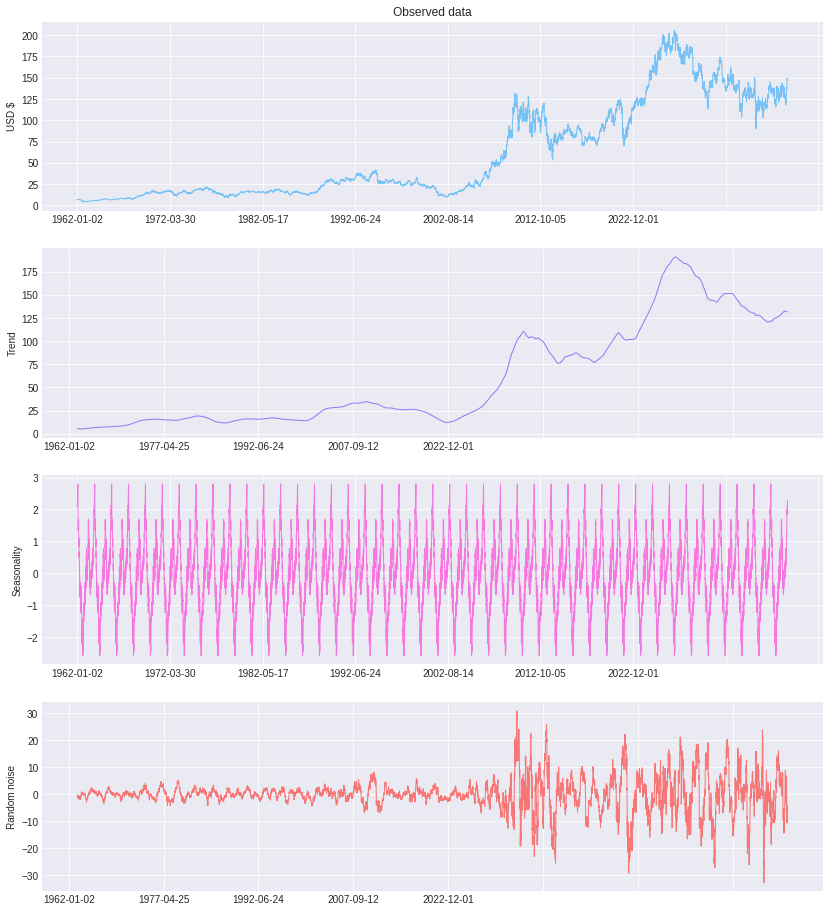

Strong evidence for Null Hypothesis
Accept Null Hypothesis - Data is not Stationary, p-value: 0.2847 > 0.05
Strong evidence against Null Hypothesis, p-value: 0.0000 < 0.05
Reject Null Hypothesis - Data is Stationary


In [ ]:
# if __name__=='__main__':
df = get_data('/content/IBM.csv')
df_new = data_preparation(df)
analyse_movement(df_new)
is_stat = ADFtest(df_new["Close"])
if not is_stat:
    df_stat = df_new.copy()
    df_stat = get_stationary_data(df_stat, ['Close'], 12)
    is_stat_new = ADFtest(df_stat["Close"])
    # plot_stationary(df_new, df_stat)

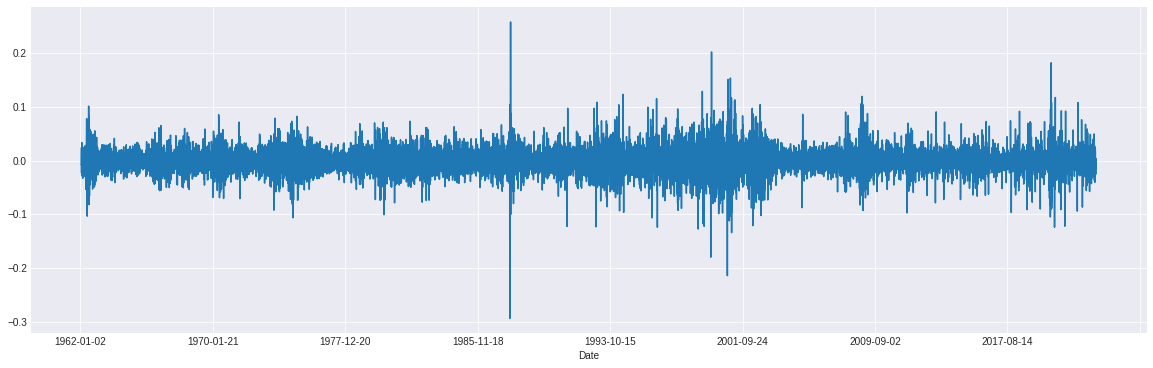

In [ ]:
# matplotlib.style.use('seaborn-darkgrid')
df_stat['Close'].plot(figsize=(20,6))

In [ ]:
# del df, df_new, is_stat, df_stat, is_stat_new
import gc
gc.collect()

0

In [ ]:
gc.collect()

0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d1f3c6a00>,
      dtype=object)

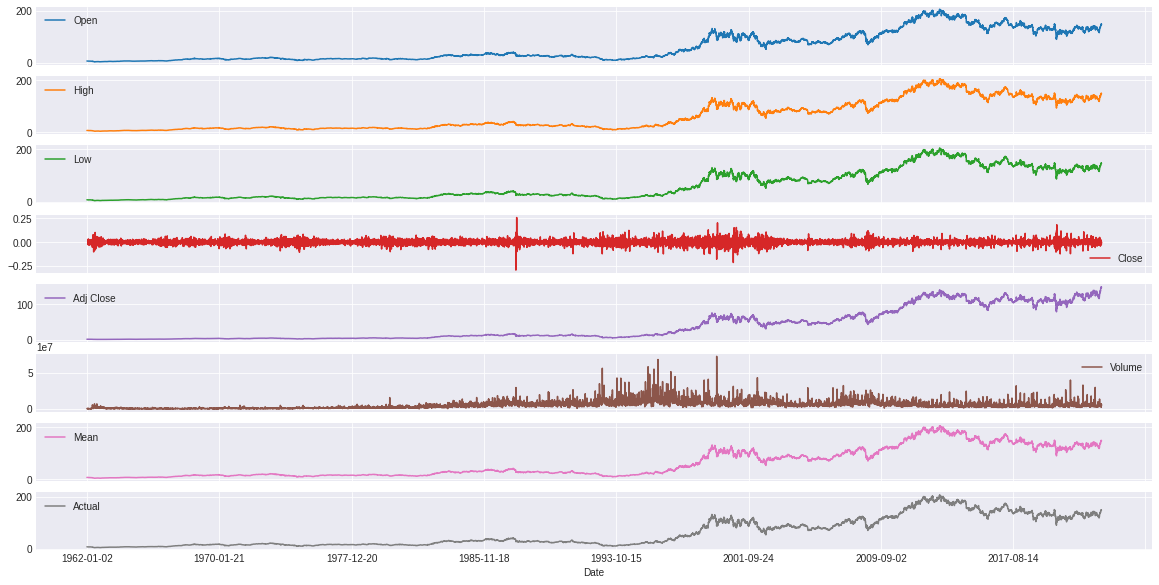

In [ ]:
df_stat.plot(figsize=(20,10),subplots=True)

In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.9 MB/s 


In [ ]:
# Standard packages
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import mean_squared_error, r2_score
from torchmetrics import R2Score, MeanAbsolutePercentageError
import time

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import plotly.graph_objects as go
sns.set_style('darkgrid')
import os
os.environ['KMP_WARNINGS'] = 'off'


class Classifier(object):
    def __init__(self, model):
        self.model = model

    def train(self, train_data, val_data, params):
        '''
            Input: train_data - list of input values (numpy array) and target values
                                (numpy array) of training data
                   model - model to be trained
                   show_progress - if the training process is showed (boolean)
        '''
        # self.x_train, self.y_train = train_data
        # self.x_val, self.y_val = val_data
        self.training_loader = train_data
        self.validation_loader = val_data
        criterion = torch.nn.MSELoss(reduction='mean')
        optimiser = torch.optim.Adam(self.model.parameters(), lr=params.lr)
        hist = np.zeros(params.n_epochs)
        hist_val = np.zeros(params.n_epochs)
        hist_r2_train = np.zeros(params.n_epochs)
        hist_r2_val = np.zeros(params.n_epochs)
        

        for epoch in range(params.n_epochs):

            self.model.train()
            for x_tr, y_tr in self.training_loader:
              # y_train_pred = self.model(self.x_train)
              y_train_pred = self.model(x_tr)
              # loss = criterion(y_train_pred, self.y_train)
              loss = criterion(y_train_pred, y_tr)
              optimiser.zero_grad()
              loss.backward()
              optimiser.step()
              hist[epoch] = loss.item()

            self.model.eval()
            for x_val in self.validation_loader:
            # y_val_pred = self.model(self.x_val)
              y_val_pred = self.model(x_val)
              val_loss = criterion(y_val_pred, self.y_val)
              hist_val[epoch] = val_loss.item()

            ## MAPE
            mean_abs_percentage_error = MeanAbsolutePercentageError()
            mape_train = mean_abs_percentage_error(y_train_pred, self.y_train)
            mape_val = mean_abs_percentage_error(y_val_pred, self.y_val)
            #R2
            r2score = R2Score()
            r2score_train = r2score(y_train_pred, self.y_train)
            r2score_val = r2score(y_val_pred, self.y_val)
            hist_r2_train[epoch] = r2score_train.item()
            hist_r2_val[epoch] = r2score_val.item()


            print(f'Epoch: {epoch+1}/{params.n_epochs}\tMSE loss: {loss.item():.5f}, R2 loss: {r2score_train.item():.3f}, MAPE loss: {mape_train.item():.3f}, MSE val_loss: {val_loss.item():.5f}, R2 val_loss: {r2score_val.item():.3f}, MAPE val_loss: {mape_val.item():.3f}')
            print('--------')

            del mean_abs_percentage_error, mape_train, mape_val, r2score, r2score_train, r2score_val

        return hist, hist_val, hist_r2_train, hist_r2_val

    def train_model(self, train_data, params):
      
      since = time.time()

      # best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0
      criterion = torch.nn.MSELoss(reduction='mean')
      optimiser = torch.optim.Adam(self.model.parameters(), lr=params.lr)

      for epoch in range(1,params.n_epochs+1):
          print(f'Epoch {epoch}/{params.n_epochs}')
          # print('-' * 10)

          # Each epoch has a training and validation phase
          for phase in ['train', 'val']:
              if phase == 'train':
                  self.model.train()  # Set model to training mode
              else:
                  self.model.eval()   # Set model to evaluate mode

              running_loss = 0.0
              running_val_loss = 0.0
              running_mape = 0
              running_r2 = 0

              # Iterate over data.
              for x, y in tqdm(train_data[phase]):
                  # inputs = inputs.to(device)
                  # labels = labels.to(device)

                  # zero the parameter gradients
                  optimiser.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = self.model(x)
                      loss = criterion(outputs, y)
                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimiser.step()
                          

                  # statistics
                  if phase=='train':
                    running_loss += loss.item() #* inputs.size(0)
                  else:
                    running_val_loss += loss.item()
                  # running_corrects += torch.sum(preds == labels.data)
              # if phase == 'train':
              #     scheduler.step()

          epoch_loss_tr = running_loss / len(train_data['train'])
          epoch_loss_val = running_val_loss / len(train_data['val'])
          # epoch_acc = running_corrects.double() / dataset_sizes[phase]

          print(f'Training Loss: {epoch_loss_tr:.4f}, Validation Loss: {epoch_loss_val:.4f}')

              # deep copy the model
              # if phase == 'val' and epoch_acc > best_acc:
              #     best_acc = epoch_acc
              #     best_model_wts = copy.deepcopy(model.state_dict())

          # print()

      time_elapsed = time.time() - since
      print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
      # print(f'Best val Acc: {best_acc:4f}')

      # load best model weights
      # model.load_state_dict(best_model_wts)
      return


    def predict(self, test_data, scaler, data_scaled=True):
        '''
            Input: test_data - list of input values (numpy array) and target values
                               (numpy array) of validation data
                   scaler - scaler object to inversely scale predictions
                   data_scaled - if scaler were used in the preprocessing (boolean)
            Output: predictions - numpy array of the predicted values
        '''


        self.x_test, self.y_test = test_data
        self.model.eval()
        predictions = self.model(self.x_test).detach().numpy()
        if data_scaled:
            predictions = scaler.inverse_transform(predictions)

        return predictions


    def predict_dataloader(self, test_data, scaler, data_scaled=True):
        '''
            Input: test_data - list of input values (numpy array) and target values
                               (numpy array) of validation data
                   scaler - scaler object to inversely scale predictions
                   data_scaled - if scaler were used in the preprocessing (boolean)
            Output: predictions - numpy array of the predicted values
        '''


        # self.x_test, self.y_test = test_data
        self.model.eval()
        predictions = []
        for x,y in test_data:
          predictions.append(self.model(x).detach().numpy())
        predictions = np.asarray(predictions).reshape((-1,1))
        print('ok preds! shape: ', predictions.shape)
        if data_scaled:
            predictions = scaler.inverse_transform(predictions)

        return predictions

def plot_predictions(df, train_data_size, predictions, model_name:str):
    '''
        Input: df - dataframe of stock values
               train_data_size - length of the training data, number of elements (int)
               predictions - numpy array of the prdicted values
    '''
    colors = ['#579BF5', '#C694F6', '#F168F1']
    fig = go.Figure()
    train = df[:train_data_size]
    valid = df[train_data_size:][:-2]
    valid['Predictions'] = predictions
    RMSE = np.sqrt(mean_squared_error(predictions, valid['Adj Close'].values))
    x_train = [str(train.index[i]).split()[0] for i in range(len(train))]
    x_val = [str(valid.index[i]).split()[0] for i in range(len(valid))]

    fig.add_trace(
        go.Scatter(x=x_train, y=train['Adj Close'], mode='lines', line_color=colors[0], line_width=2,
                   name='Training data'))

    fig.add_trace(
        go.Scatter(x=x_val, y=valid['Adj Close'], mode='lines', line_color=colors[1], line_width=2,
                   name='Validation data'))

    fig.add_trace(
        go.Scatter(x=x_val, y=valid['Predictions'], mode='lines', line_color=colors[2], line_width=2,
                   name='Predictions'))

    fig.update_layout(showlegend=True)
    fig.update_layout(title=dict(text=f'Predictions of stock "{train["Company stock name"][0]}" from {x_val[0]} to {x_val[len(valid) - 1]}',
                                 xanchor='auto'),
                      xaxis=go.layout.XAxis(
                          title=go.layout.xaxis.Title(
                              text="Date")),
                      yaxis=go.layout.YAxis(
                          title=go.layout.yaxis.Title(
                              text="Adjusted closing price USD ($)"))
                      )
    # fig.write_image(f'./demonstration_images/{model_name}_predictions.png')
    fig.show()

def mape(actual, pred): 
  actual, pred = np.array(actual), np.array(pred)
  return np.mean(np.abs((actual - pred) / actual)) * 100

from sklearn.metrics import mean_absolute_error

def plot_predictions_test(df, predictions):
    '''
        Input: df - dataframe of stock values
               train_data_size - length of the training data, number of elements (int)
               predictions - numpy array of the prdicted values
    '''
    colors = ['#579BF5', '#C694F6', '#F168F1']
    fig = go.Figure()
    # train = df[:train_data_size]
    # valid = df[train_data_size:][:-2]
    # valid['Predictions'] = predictions
    df = df[31:]
    RMSE = np.sqrt(mean_squared_error(predictions['Predictions'], df['Actual'].values))
    MAPE = mape(df['Actual'].values, predictions['Predictions'].values)
    MAE = mean_absolute_error(df['Actual'].values, predictions['Predictions'].values)
    R2_score = r2_score(df['Actual'].values, predictions['Predictions'].values)

    print(f'RMSE of test set: {RMSE}')
    print(f'MAE of test set: {MAE}')
    print(f'MAPE % of test set: {MAPE}')
    print(f'R2 % of test set: {R2_score*100}')

    # x_train = [str(train.index[i]).split()[0] for i in range(len(train))]
    # x_val = [str(valid.index[i]).split()[0] for i in range(len(valid))]

    fig.add_trace(
        go.Scatter(x=df.index, y=df['Actual'], mode='lines', line_color=colors[0], line_width=2,
                   name='Test data'))

    fig.add_trace(
        go.Scatter(x=predictions.index, y=predictions['Predictions'], mode='lines', line_color=colors[1], line_width=2,
                   name='Validation data'))

    # fig.add_trace(
    #     go.Scatter(x=x_val, y=valid['Predictions'], mode='lines', line_color=colors[2], line_width=2,
    #                name='Predictions'))

    fig.update_layout(showlegend=True)
    fig.update_layout(title=dict(text=f'Predictions of stock "{df["Company stock name"][0]}" from {df.index[0]} to {df.index[-1]}',
                                 xanchor='auto'),
                      xaxis=go.layout.XAxis(
                          title=go.layout.xaxis.Title(
                              text="Date")),
                      yaxis=go.layout.YAxis(
                          title=go.layout.yaxis.Title(
                              text="Closing Price USD ($)"))
                      )
    # fig.write_image(f'./demonstration_images/{model_name}_predictions.png')
    fig.show()

def plot_predictions_test_adj_close(df, predictions):
    '''
        Input: df - dataframe of stock values
               train_data_size - length of the training data, number of elements (int)
               predictions - numpy array of the prdicted values
    '''
    colors = ['#579BF5', '#C694F6', '#F168F1']
    fig = go.Figure()
    # train = df[:train_data_size]
    # valid = df[train_data_size:][:-2]
    # valid['Predictions'] = predictions
    df = df[31:]
    RMSE = np.sqrt(mean_squared_error(predictions['Predictions'], df['Adj Close'].values))
    MAPE = mape(df['Adj Close'].values, predictions['Predictions'].values)
    MAE = mean_absolute_error(df['Adj Close'].values, predictions['Predictions'].values)

    print(f'RMSE of test set: {RMSE}')
    print(f'MAE of test set: {MAE}')
    print(f'MAPE of test set: {MAPE}')

    # x_train = [str(train.index[i]).split()[0] for i in range(len(train))]
    # x_val = [str(valid.index[i]).split()[0] for i in range(len(valid))]

    fig.add_trace(
        go.Scatter(x=df.index, y=df['Adj Close'], mode='lines', line_color=colors[0], line_width=2,
                   name='Test data'))

    fig.add_trace(
        go.Scatter(x=predictions.index, y=predictions['Predictions'], mode='lines', line_color=colors[1], line_width=2,
                   name='Validation data'))

    # fig.add_trace(
    #     go.Scatter(x=x_val, y=valid['Predictions'], mode='lines', line_color=colors[2], line_width=2,
    #                name='Predictions'))

    fig.update_layout(showlegend=True)
    fig.update_layout(title=dict(text=f'Predictions of stock "{df["Company stock name"][0]}" from {df.index[0]} to {df.index[-1]}',
                                 xanchor='auto'),
                      xaxis=go.layout.XAxis(
                          title=go.layout.xaxis.Title(
                              text="Date")),
                      yaxis=go.layout.YAxis(
                          title=go.layout.yaxis.Title(
                              text="Adjusted closing price USD ($)"))
                      )
    # fig.write_image(f'./demonstration_images/{model_name}_predictions.png')
    fig.show()



In [ ]:
from torch.utils.data.dataset import Dataset

class MyCustomDataset(Dataset):
    def __init__(self, data):
        self.x = data[0].numpy()
        self.y = data[1].numpy()
        
    def __getitem__(self, index):
        x_ = self.x[index,:,:]
        y_ = self.y[index,:]
        return x_, y_

    def __len__(self):
        return self.x.shape[0] - 1 # of how many data(images?) you have
        

In [ ]:
# Standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import torch
sns.set_style('darkgrid')
plt.style.use("fivethirtyeight")

# import preprocess
# import Analysis

class GetDataset(object):
    def __init__(self, df, bs):
        super(GetDataset, self).__init__()
        self.df = df
        self.bs = bs
        self.df["Next_day_closing_price"] = df["Close"].shift(-1).dropna()
        if self.df.columns[0] == 'Date':
            self.df = self.df.set_index('Date')
        self.df["Actual"] = self.df["Next_day_closing_price"]



    def get_dataset(self, scale=True, stationary=False, indicators=False):
        '''
            Input: scale - if to scale the input data
        '''
        x_df = self.df[["Close", "Open", "High", "Low", "Volume"]].dropna()[:-1]
        y_df = self.df["Next_day_closing_price"].dropna().fillna(0)


        x_processed_df = preprocess_data(x_df).fillna(0)
        if stationary:
            for col in x_processed_df.columns:
                #if not Analysis.ADFtest(x_processed_df[col]):
                print("\nMaking data stationary...\n")
                x_processed_df = get_stationary_data(x_processed_df, [col], 12)
                #Analysis.ADFtest(x_processed_df[col])

            y_df = get_stationary_data(self.df, ["Next_day_closing_price"], 12)['Next_day_closing_price']
            y_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
        #print(x_processed_df)
        x_processed_df.replace([np.inf, -np.inf], 0, inplace=True)

        # print(x_processed_df.head())

        self.x_data_values = x_processed_df.fillna(0).values[:-1]
        self.y_data_values = y_df.values[:-1].reshape(-1, 1)

        self.x_scaler = MinMaxScaler(feature_range=(-1, 1))
        self.y_scaler = MinMaxScaler(feature_range=(-1, 1))

        if scale:
            self.x_data = self.x_scaler.fit_transform(self.x_data_values)
            self.y_data = self.y_scaler.fit_transform(self.y_data_values)
            #self.y_data = self.y_data_values
        else:
            self.x_data = self.x_data_values
            self.y_data = self.y_data_values


    def get_size(self):
        '''
            Output: returns the length of the dataset
        '''
        return len(self.x_data)


    def split(self, train_split_ratio=0.8, time_period=30):
        '''
            Input: train_split_ratio - percentage of dataset to be used for
                                       the training data (float)
                   time_period - time span in days to be predicted (in)
            Output: lists of the training and validation data (input values and target values)
                    size of the training data
        '''

        train_data_size = int(np.ceil(self.get_size() * train_split_ratio))
        x_train_data = self.x_data[:train_data_size]
        y_train_data = self.y_data[:train_data_size]

        # print(x_train_data.shape)
        # print(y_train_data.shape)

        # print(x_train_data[:2])
        # print(y_train_data[:2])

        # print(x_train[:,0])
        # print(x_train[1][:,0])
        # print(y_train[0,0])

        x_train = [x_train_data[i-time_period:i] for i in range(time_period, len(x_train_data))]
        y_train = y_train_data[time_period-1:-1]


        self.y_train = np.array(y_train)
        self.x_train = np.array(x_train)
        #self.x_train = np.reshape(np.array(x_train), (np.array(x_train).shape[0], np.array(x_train).shape[1], 1))
        print(f'Shape of train data: (x, y) = ({np.shape(self.x_train)}, {np.shape(self.y_train)})')

        x_test_data = self.x_data[train_data_size - time_period:]
        y_test = self.y_data[train_data_size-1:-1]
        x_test = [x_test_data[i-time_period:i] for i in range(time_period, len(x_test_data)+1)]

        self.y_test = np.array(y_test)
        self.x_test = np.array(x_test)
        #self.x_test = np.reshape(np.array(x_test), (np.array(x_test).shape[0], np.array(x_test).shape[1], 1))
        print(f'Shape of test data: (x, y) = ({np.shape(self.x_test)}, {np.shape(self.y_test)})')
        return [self.x_train, self.y_train], [self.x_test, self.y_test], train_data_size

    def split_test(self, time_period=30):
        '''
            Input: train_split_ratio - percentage of dataset to be used for
                                       the training data (float)
                   time_period - time span in days to be predicted (in)
            Output: lists of the training and validation data (input values and target values)
                    size of the training data
        '''

        train_data_size = int(np.ceil(self.get_size()))
        x_test_data = self.x_data#[:train_data_size]
        y_test_data = self.y_data#[:train_data_size]

        x_test = [x_test_data[i-time_period:i] for i in range(time_period, len(x_test_data)+1)]
        y_test = y_test_data[time_period-1:-1]


        self.y_test = np.array(y_test)
        self.x_test = np.array(x_test)
        #self.x_train = np.reshape(np.array(x_train), (np.array(x_train).shape[0], np.array(x_train).shape[1], 1))
        print(f'Shape of test data: (x, y) = ({np.shape(self.x_test)}, {np.shape(self.y_test)})')

        # x_test_data = self.x_data[train_data_size - time_period:]
        # y_test = self.y_data[train_data_size:]
        # x_test = [x_test_data[i-time_period:i] for i in range(time_period, len(x_test_data))]

        # self.y_test = np.array(y_test)
        # self.x_test = np.array(x_test)
        # #self.x_test = np.reshape(np.array(x_test), (np.array(x_test).shape[0], np.array(x_test).shape[1], 1))
        # print(f'Shape of test data: (x, y) = ({np.shape(self.x_test)}, {np.shape(self.y_test)})')
        return [self.x_test, self.y_test]


    def get_torchdata(self):
        self.x_train_tensor = torch.from_numpy(self.x_train).type(torch.Tensor)
        self.x_test_tensor = torch.from_numpy(self.x_test).type(torch.Tensor)

        self.y_train_tensor = torch.from_numpy(self.y_train).type(torch.Tensor)
        self.y_test_tensor = torch.from_numpy(self.y_test).type(torch.Tensor)

        # training_loader = torch.utils.data.DataLoader([self.x_train_tensor,self.y_train_tensor], batch_size=self.bs, shuffle=False, num_workers=2)
        # validation_loader = torch.utils.data.DataLoader([self.x_test_tensor,self.y_test_tensor], batch_size=self.bs, shuffle=False, num_workers=2)

        return [self.x_train_tensor, self.y_train_tensor], [self.x_test_tensor, self.y_test_tensor]
        # return training_loader, validation_loader

    def get_torchdata_test(self):
        self.x_test_tensor = torch.from_numpy(self.x_test).type(torch.Tensor)
        self.y_test_tensor = torch.from_numpy(self.y_test).type(torch.Tensor)

        # test_loader = torch.utils.data.DataLoader([self.x_test_tensor,self.y_test_tensor], batch_size=self.bs, shuffle=False, num_workers=2)
        return [self.x_test_tensor, self.y_test_tensor]
        # return test_loader
    

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f


def scaled_dot_product_attention(query, key, value):
    '''
    Computes the local fields and the attention of the inputs as described in Vaswani et. al.
    and then scale it for a total sum of 1
    INPUT: query, key, value - input data of size (batch_size, seq_length, num_features)
    '''

    temp = query.bmm(key.transpose(1, 2))
    scale = query.size(-1) ** 0.5
    softmax = f.softmax(temp / scale, dim=-1)
    attention = softmax.bmm(value)
    return attention


class MultiHeadAttention(nn.Module):
    '''
    Computes the multihead head consisting of a feedforward layer for each input value
    where the attention for all of these are computed for each head and then concatenated and projected
    as described in Vaswani et. al.
    INPUT: dimensions of the three matrices (where the key and query matrix has the same dimensions) and the nr of heads
    OUTPUT: the projected output of the multihead attention
    '''

    def __init__(self, num_heads, input_dim, key_dim, value_dim):
        super().__init__()
        self.query = nn.Linear(input_dim, key_dim)
        self.key = nn.Linear(input_dim, key_dim)
        self.value = nn.Linear(input_dim, value_dim)
        self.num_heads = num_heads

        self.linear = nn.Linear(num_heads * value_dim, input_dim)

    def forward(self, query, key, value):
        multiheads_out = [
            scaled_dot_product_attention(self.query(query), self.key(key), self.value(value)) for _ in
            range(self.num_heads)
        ]
        out = self.linear(torch.cat(multiheads_out, dim=-1))
        return out


def positioning_encoding(seq_length, model_dim):
    '''
    Computes the positional encoding for the current state of the elements in the input sequence as
    there is no recurrence or convolution. Using the same encoding with sinusosoidal functions as in Vaswani et. al.
    as the motivations of linearly dependency of the relative positions and the ability to extrapolate to sequence lengths
    longer than encountered in training holds strong.
    Code copied from Frank Odom
    INPUT: length of the input sequence and the dimension of the model
    OUTPUT: Encoded relative positions of the data points in the input sequence
    '''
    position = torch.arange(seq_length, dtype=torch.float).reshape(1, -1, 1)
    frequencies = 1e-4 ** (2 * (torch.arange(model_dim, dtype=torch.float) // 2) / model_dim).reshape(1, 1, -1)
    pos_enc = position * frequencies
    pos_enc[:, ::2] = torch.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = torch.sin(pos_enc[:, 1::2])
    return pos_enc


def forward(input_dim=512, forward_dim=2048):
    '''
    Forward class for the feed-forward layer that is following the multihead
    attention layers
    INPUT: input dimension and the layer size of the forward layer
    OUTPUT: feed-forward layer (nn.Module)
    '''
    forward_layer = nn.Sequential(
        nn.Linear(input_dim, forward_dim),
        nn.ReLU(),
        nn.Linear(forward_dim, input_dim)
    )
    return forward_layer


class ResidualConnection(nn.Module):
    '''
    Class for the residual connections for the encoder and the decoder, used for each multihead attention layer
    and for each feed-forward layer
    INPUT: type of layer, dimension for the layer normalization and dropout probability factor
    OUTPUT: Normalized and processed tensors added to the input tensors
    '''

    def __init__(self, layer, dimension, dropout=0.2):
        super().__init__()
        self.layer = layer
        self.norm = nn.LayerNorm(dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, *X):
        return self.norm(X[-1] + self.dropout(self.layer(*X)))


class Encoder(nn.Module):
    '''
    The encoder of the transformer model, first computes the relative positions of the inputs, then feeds it into
    the multihead attention followed by the feed-forward layer, both with normalized residual connections
    '''

    def __init__(self, n_layers=6, model_dim=512, num_heads=8, forward_dim=2048, dropout=0.2):
        super().__init__()

        self.n_layers = n_layers
        key_dim = value_dim = model_dim // num_heads

        # Multihead attention layer with normalized residual connections and dropout
        self.multihead_attention = ResidualConnection(
            MultiHeadAttention(num_heads, model_dim, key_dim, value_dim),
            dimension=model_dim,
            dropout=dropout
        )
        # Feed-forward layer with normalized residual connections and dropout
        self.feed_forward = ResidualConnection(
            forward(model_dim, forward_dim),
            dimension=model_dim,
            dropout=dropout
        )

    def forward(self, X):
        seq_length, dimension = X.size(1), X.size(2)
        out = X
        # Computes the positional encodings
        out += positioning_encoding(seq_length, dimension)
        # Feeds the input to the multihead attention layer followed by the feed-forward
        # layer for 'n_layers' many layers
        for _ in range(self.n_layers):
            att_out = self.multihead_attention(out, out, out)
            out = self.feed_forward(att_out)
        return out


class TransformerModel_v01(nn.Module):
    '''
    Transformer model that combines the encoder and the decoder
    "model_dim" must be the same size as "num_features" in the input data (i.e size last dimension),
    otherwise freely tunable parameters
    '''

    def __init__(self, n_layers=6, model_dim=512, output_dim=512,
                 num_heads=6, forward_dim=2048, dropout=0.2):
        super().__init__()
        self.encoder = Encoder(n_layers, model_dim, num_heads, forward_dim, dropout)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(16, output_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        enc_out = self.encoder(X)
        #flat = self.flatten(enc_out)
        out = self.relu(self.linear(enc_out[:, -1, :]))
        return out


# Test with random tensors
#X = torch.rand(32, 64, 32)
#out = TransformerModel(model_dim=32, output_dim=50)(X)
#print(out.shape)

In [ ]:
import torch.nn as nn
import torch
import os
# import transformer

class ModelUtils:
    '''
    A utility class to save and load model weights
    '''
    def save_model(self, save_path, model):
        root, ext = os.path.splitext(save_path)
        if not ext:
            save_path = root + '.pth'
        try:
            torch.save(model.state_dict(), save_path)
            print(f'Successfully saved to model to "{save_path}"!')
        except Exception as e:
            print(f'Unable to save model, check save path!')
            print(f'Exception:\n{e}')
            return None

    def load_model(self, load_path, model):
        try:
            model.load_state_dict(torch.load(load_path))
            print(f'Successfully loaded the model from path "{load_path}"')

        except Exception as e:
            print(f'Unable to load the weights, check if different model or incorrect path!')
            print(f'Exception:\n{e}')
            return None

class rnn_params:
    rnn_type = 'lstm'
    input_dim = 16
    hidden_dim = 2048
    num_layers = 1
    output_dim = 1
    n_epochs = 100
    lr = 0.00001

class transf_params:
    n_layers = 11
    num_heads = 12
    model_dim = 16  # nr of features
    forward_dim = 2048
    output_dim = 1
    dropout = 0.1 #0
    n_epochs = 1 #100
    lr = 0.01

class TransformerModel(nn.Module):
    def __init__(self, params):
        super(TransformerModel, self).__init__()
        # self.params = params
        # print(params.n_layers)
        self.transf = TransformerModel_v01(n_layers=params.n_layers,
                                       num_heads=params.num_heads,
                                       model_dim=params.model_dim,
                                       forward_dim=params.forward_dim,
                                       output_dim=16,
                                       dropout=params.dropout)
        self.linear = nn.Linear(16, params.output_dim)
    def forward(self, x):
        transf_out = self.transf(x)
        out = self.linear(transf_out)
        return out


class TorchRNN(nn.Module):
    def __init__(self, rnn_type, input_dim, hidden_dim, num_layers, output_dim):
        super(TorchRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        else:
            raise KeyError('Invalid RNN type, select "lstm" or "gru"!')
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        if self.rnn_type == 'lstm':
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
            out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach()))
        elif self.rnn_type == 'gru':
            out, (hn) = self.rnn(x, (h0.detach()))
        else:
            raise KeyError('Invalid RNN type, select "lstm" or "gru"!')
        out = self.relu(self.fc1(out[:, -1, :]))
        out = self.fc2(out)
        return out

In [ ]:
pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 90 kB/s 


In [ ]:
# Standard packages
import pandas as pd

# Scripts
# from preprocess import config, get_timestamps, collect_data, plot_closing, plot_gain, compare_stocks
# from models import TorchRNN, rnn_params, transf_params, TransformerModel
# from dataset import GetDataset
# from train import Classifier, plot_predictions
# import Analysis


def visualization():
    for idx, stock in enumerate(config.stock_names):
        timestamps = get_timestamps(config.yrs, config.mths, config.dys)
        df = collect_data(timestamps, stock, config.moving_averages, True)
        fig1 = plot_closing(df, moving_averages=True, intervals=None)
        fig1.show()
        fig2 = plot_gain(df)
        fig2.show()
        daily_returns, fig1_c, fig2_c = compare_stocks(config.stock_names_compare, timestamps)


def run(stock: str, model_type: str, stationary=True, bs=64):
    df = get_data(stock)
    # df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
    # print(df.describe())
    df["Company stock name"] = stock.split('/')[-1].split('.')[0]
    df = df[df.index >= '2010-01-01']
    ## Training
    df_training = df.iloc[:int(len(df)*0.8),:]
    print(f'Training shape: {df_training.shape}')
    ## Testing
    df_testing = df.iloc[int(len(df)*0.8):,:]
    print(f'Testing shape: {df_testing.shape}')

    dataset = GetDataset(df_training, bs)
    dataset.get_dataset(scale=False, stationary=stationary)
    train_data, val_data, train_data_len = dataset.split(train_split_ratio=0.8, time_period=30)
    train_data, val_data = dataset.get_torchdata()
    x_train, y_train = train_data
    x_val, y_val = val_data

    dataset = GetDataset(df_testing, bs)
    dataset.get_dataset(scale=False, stationary=stationary)
    test_data = dataset.split_test(time_period=30)
    test_data = dataset.get_torchdata_test()
    x_test, y_test = test_data

    # print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

    training_dataset = MyCustomDataset([x_train, y_train])
    validation_dataset = MyCustomDataset([x_val, y_val])
    testing_dataset = MyCustomDataset([x_test, y_test])
    # print(training_dataset.__getitem__(2049))

    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=False, num_workers=2, drop_last=False)
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=2, drop_last=False)
    testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=1, shuffle=False, num_workers=2, drop_last=False)

    # # Checking the dataset
    # for images, labels in training_loader:  
    #     print('Image batch dimensions:', images.shape)
    #     print('Image label dimensions:', labels.shape)
    #     break

    if model_type == 'lstm':
        params = rnn_params
        model = TorchRNN(rnn_type=params.rnn_type, input_dim=params.input_dim,
                         hidden_dim=params.hidden_dim, output_dim=params.output_dim,
                         num_layers=params.num_layers)
    elif model_type == 'transformer':
        params = transf_params
        model = TransformerModel(params)
    else:
        raise ValueError('Wrong model type selection, select either "rnn" or "transformer"!')

    clf = Classifier(model)
    # history_train, history_val, hist_r2_tr, hist_r2_val = clf.train([x_train, y_train], [x_val, y_val] , params=params)
    clf.train_model(train_data={'train': training_loader, 'val': validation_loader}, params=params)

    # plt.plot(history_train)
    # plt.plot(history_val)
    # plt.title('MSE Loss')

    # plt.figure()
    # plt.plot(hist_r2_tr)
    # plt.plot(hist_r2_val)
    # plt.title('R2 Score')

    y_scaler = dataset.y_scaler
    # predictions = clf.predict([x_test, y_test], y_scaler, data_scaled=False)
    predictions = clf.predict_dataloader(testing_loader, y_scaler, data_scaled=False)
    predictions = pd.DataFrame(predictions)
    predictions.reset_index(drop=True, inplace=True)
    print('Preds shape: ',predictions.shape)
    # predictions.index = df.index[-len(x_test):]
    predictions.index = df_testing.index[-len(x_test)+1:]
    predictions['Actual'] = y_test[:-1]
    # predictions['Actual'] = y_test
    predictions.rename(columns={0: 'Predictions'}, inplace=True)
    if stationary:
        predictions = inverse_stationary_data(old_df=df_testing, new_df_=predictions,
                                                       orig_feature='Actual', new_feature='Predictions',
                                                       diff=12, do_orig=False)
    return df_testing, predictions
    # plot_predictions(df_testing, train_data_len, predictions["Predictions"].values, model_type)


# if __name__ == '__main__':
    # visualization()
df_testing, predictions = run('/content/IBM.csv', 'transformer', True, 64)

Training shape: (2601, 7)
Testing shape: (651, 7)

Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...

Shape of train data: (x, y) = ((2050, 30, 16), (2050, 1))
Shape of test data: (x, y) = ((520, 30, 16), (520, 1))

Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary..

100%|██████████| 9/9 [00:02<00:00,  3.79it/s]

Training Loss: 0.0000, Validation Loss: 0.0008
Training complete in 0m 24s


ok preds! shape:  (619, 1)
Preds shape:  (619, 1)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b4104a100>,
      dtype=object)

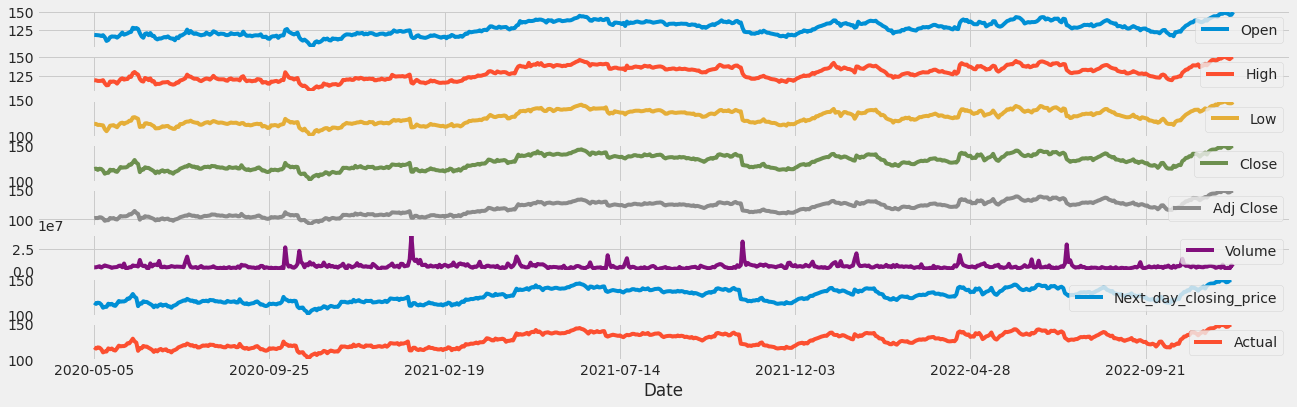

In [ ]:
df_testing.plot(subplots=True,figsize=(20,6))

In [ ]:
df_testing

,Open,High,Low,Close,Adj Close,Volume,Company stock name,Next_day_closing_price,Actual
Date,,,,,,,,,
2020-05-05,117.963669,118.852776,117.084129,117.189293,102.061035,4078772,IBM,117.753349,117.753349
2020-05-06,117.820267,118.594643,117.026772,117.753349,102.552254,4042372,IBM,115.898659,115.898659
2020-05-07,117.571701,117.839386,115.535370,115.898659,102.290710,4615580,IBM,117.581261,117.581261
2020-05-08,117.275337,117.810707,115.736137,117.581261,103.775742,5232615,IBM,117.198853,117.198853
2020-05-11,116.453156,118.021034,115.363289,117.198853,103.438225,3697924,IBM,114.971321,114.971321
...,...,...,...,...,...,...,...,...,...
2022-11-25,148.270004,149.490005,148.100006,148.369995,148.369995,2075200,IBM,146.179993,146.179993
2022-11-28,147.979996,148.240005,145.940002,146.179993,146.179993,3538100,IBM,146.490005,146.490005
2022-11-29,145.910004,147.169998,145.699997,146.490005,146.490005,2754700,IBM,148.899994,148.899994


In [ ]:
predictions

,Predictions,Actual
Date,,
2020-06-19,116.441035,-0.007942
2020-06-22,118.087457,-0.008768
2020-06-23,116.848843,-0.037623
2020-06-24,107.658643,-0.010257
2020-06-25,111.592343,-0.038103
...,...,...
2022-11-25,144.942567,-0.001984
2022-11-28,149.625844,-0.012376
2022-11-29,147.869945,-0.014772


In [ ]:
# with dropout
plot_predictions_test(df_testing.dropna(), predictions)

RMSE of test set: 2.027797188378336
MAE of test set: 1.4502580397561091
MAPE % of test set: 1.1463438149902676
R2 % of test set: 95.28223738703237


In [ ]:
# with dropout
plot_predictions_test(df_testing.dropna(), predictions[:-1])

RMSE of test set: 2.856161382434489
MAE of test set: 2.068693677674972
MAPE of test set: 1.6361168265672335


In [ ]:
plot_predictions_test(df_testing.dropna(), predictions[:-1])

RMSE of test set: 2.8565434096159557
MAE of test set: 2.0695318127629454
MAPE of test set: 1.636760638327291


In [1]:
# with dropout
# plot_predictions_test_adj_close(df_testing.dropna(), predictions[:-1])

In [2]:
# plot_predictions_test_adj_close(df_testing.dropna(), predictions[:-1])

In [3]:
# get_stationary_data(predictions, ['Predictions'], 12).plot()

In [ ]:
# colors = ['#579BF5', '#C694F6', '#F168F1']
# fig = go.Figure()
# fig.add_trace(
#         go.Scatter(x=df_testing[31:].index, y=df_testing[31:]['Adj Close'], mode='lines', line_color=colors[0], line_width=2,
#                    name='Test data'))

# fig.add_trace(
#     go.Scatter(x=predictions.index, y=predictions['Predictions'], mode='lines', line_color=colors[1], line_width=2,
#                 name='Validation data'))

# # fig.add_trace(
# #     go.Scatter(x=x_val, y=valid['Predictions'], mode='lines', line_color=colors[2], line_width=2,
# #                name='Predictions'))

# fig.update_layout(showlegend=True)
# fig.update_layout(title=dict(text=f'Predictions of stock "{df_testing["Company stock name"][0]}" from {df_testing.index[0]} to {df_testing.index[-1]}',
#                               xanchor='auto'),
#                   xaxis=go.layout.XAxis(
#                       title=go.layout.xaxis.Title(
#                           text="Date")),
#                   yaxis=go.layout.YAxis(
#                       title=go.layout.yaxis.Title(
#                           text="Adjusted closing price USD ($)"))
#                   )

#### Debugging run function

In [ ]:
def run_debug(stock: str,  stationary=True):
    df = get_data(stock)
    # df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
    # print(df.describe())
    df["Company stock name"] = stock.split('/')[-1].split('.')[0]
    df = df[df.index >= '2010-01-01']
    ## Training
    df_training = df.iloc[:int(len(df)*0.8),:]
    print(f'Training shape: {df_training.shape}')
    ## Testing
    df_testing = df.iloc[int(len(df)*0.8):,:]
    print(f'Testing shape: {df_testing.shape}')

    dataset = GetDataset(df_training)
    dataset.get_dataset(scale=False, stationary=stationary)
    train_data, val_data, train_data_len = dataset.split(train_split_ratio=0.8, time_period=30)
    # train_data, val_data = dataset.get_torchdata()
    x_train, y_train = train_data
    x_val, y_val = val_data

    dataset = GetDataset(df_testing)
    dataset.get_dataset(scale=False, stationary=stationary)
    test_data = dataset.split_test(time_period=30)
    # test_data = dataset.get_torchdata_test()
    # x_test, y_test = test_data

    # if model_type == 'lstm':
    #     params = rnn_params
    #     model = TorchRNN(rnn_type=params.rnn_type, input_dim=params.input_dim,
    #                      hidden_dim=params.hidden_dim, output_dim=params.output_dim,
    #                      num_layers=params.num_layers)
    # elif model_type == 'transformer':
    #     params = transf_params
    #     model = TransformerModel(params)
    # else:
    #     raise ValueError('Wrong model type selection, select either "rnn" or "transformer"!')

    # clf = Classifier(model)
    # history_train, history_val = clf.train([x_train, y_train], [x_val, y_val] , params=params)
    # plt.plot(history_train)
    # plt.plot(history_val)
    # y_scaler = dataset.y_scaler
    # predictions = clf.predict([x_test, y_test], y_scaler, data_scaled=False)
    # predictions = pd.DataFrame(predictions)
    # predictions.reset_index(drop=True, inplace=True)
    # predictions.index = df.index[-len(x_test):]
    # #predictions['Actual'] = y_test[:-1]
    # predictions['Actual'] = y_test
    # predictions.rename(columns={0: 'Predictions'}, inplace=True)
    # if stationary:
    #     predictions = inverse_stationary_data(old_df=df_testing, new_df_=predictions,
    #                                                    orig_feature='Actual', new_feature='Predictions',
    #                                                    diff=12, do_orig=False)
    return x_val, y_val

sample_train = run_debug('/content/IBM.csv', True)

Training shape: (2601, 7)
Testing shape: (651, 7)

Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...

(2080, 16)
(2080, 1)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.]
 [0.]]
Shape of train data: (x, y) = ((2050, 30, 16), (2050, 1))
Shape of test data: (x, y) = ((520, 30, 16), (520, 1))


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in log




Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...


Making data stationary...

Shape of test data: (x, y) = ((620, 30, 16), (620, 1))


In [ ]:
sample_train[0][0][:,0]

array([ 0.02912298,  0.02865619, -0.01753497, -0.02560957,  0.00871383,
       -0.01045483, -0.01591237,  0.01546979, -0.00686472,  0.02741466,
        0.01102471, -0.0210434 , -0.0270454 ,  0.02226287,  0.00867395,
       -0.00527727, -0.01174672, -0.0126658 , -0.02192904, -0.03782358,
        0.04306264, -0.02921581, -0.00193797,  0.01183136, -0.01458202,
       -0.01084614,  0.02403255,  0.01774073, -0.01538385,  0.01084944])

In [ ]:
sample_train[0][1][:,0]

array([ 0.02865619, -0.01753497, -0.02560957,  0.00871383, -0.01045483,
       -0.01591237,  0.01546979, -0.00686472,  0.02741466,  0.01102471,
       -0.0210434 , -0.0270454 ,  0.02226287,  0.00867395, -0.00527727,
       -0.01174672, -0.0126658 , -0.02192904, -0.03782358,  0.04306264,
       -0.02921581, -0.00193797,  0.01183136, -0.01458202, -0.01084614,
        0.02403255,  0.01774073, -0.01538385,  0.01084944,  0.04732529])

In [ ]:
sample_train[0][2][:,0]

array([-0.01753497, -0.02560957,  0.00871383, -0.01045483, -0.01591237,
        0.01546979, -0.00686472,  0.02741466,  0.01102471, -0.0210434 ,
       -0.0270454 ,  0.02226287,  0.00867395, -0.00527727, -0.01174672,
       -0.0126658 , -0.02192904, -0.03782358,  0.04306264, -0.02921581,
       -0.00193797,  0.01183136, -0.01458202, -0.01084614,  0.02403255,
        0.01774073, -0.01538385,  0.01084944,  0.04732529,  0.02107159])

In [ ]:
sample_train[0][3][:,0]

array([-0.02560957,  0.00871383, -0.01045483, -0.01591237,  0.01546979,
       -0.00686472,  0.02741466,  0.01102471, -0.0210434 , -0.0270454 ,
        0.02226287,  0.00867395, -0.00527727, -0.01174672, -0.0126658 ,
       -0.02192904, -0.03782358,  0.04306264, -0.02921581, -0.00193797,
        0.01183136, -0.01458202, -0.01084614,  0.02403255,  0.01774073,
       -0.01538385,  0.01084944,  0.04732529,  0.02107159, -0.01235261])

In [ ]:
sample_train[1][:5]

array([[ 0.04732529],
       [ 0.02107159],
       [-0.01235261],
       [ 0.00092411],
       [ 0.00349406]])

In [ ]:
import numpy as np
import pandas as pd
import os, datetime
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.9.2


In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14581513219732213854
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11248434549784174490
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable first GPU
  tf.config.set_visible_devices(physical_devices[1:], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  # Logical device was not created for first GPU
  assert len(logical_devices) == len(physical_devices) - 1
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [ ]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
df = pd.read_csv(r'/content/IBM.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,7.374124,7.374124,7.291268,7.291268,1.633034,407940
1,1962-01-03,7.291268,7.355003,7.291268,7.355003,1.647308,305955
2,1962-01-04,7.355003,7.355003,7.278521,7.281708,1.630893,274575
3,1962-01-05,7.272148,7.272148,7.125558,7.138305,1.598774,384405
4,1962-01-08,7.131931,7.131931,6.947100,7.004461,1.568796,572685
...,...,...,...,...,...,...,...
15331,2022-11-25,148.270004,149.490005,148.100006,148.369995,148.369995,2075200
15332,2022-11-28,147.979996,148.240005,145.940002,146.179993,146.179993,3538100
15333,2022-11-29,145.910004,147.169998,145.699997,146.490005,146.490005,2754700
15334,2022-11-30,146.190002,149.639999,145.669998,148.899994,148.899994,6377600


In [ ]:
# df = df.rename(columns={'Close/Last':'Close'})

In [ ]:
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15336 entries, 0 to 15335
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    15336 non-null  object 
 1   Open    15336 non-null  float64
 2   High    15336 non-null  float64
 3   Low     15336 non-null  float64
 4   Close   15336 non-null  float64
 5   Volume  15336 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 719.0+ KB


## Preprocessing

In [ ]:
df.Date = pd.to_datetime(df.Date)
# df['Close'] = df['Close'].apply(lambda x: x.split('$')[1]) 
# df['Open'] = df['Open'].apply(lambda x: x.split('$')[1]) 
# df['High'] = df['High'].apply(lambda x: x.split('$')[1]) 
# df['Low'] = df['Low'].apply(lambda x: x.split('$')[1]) 
df

,Date,Open,High,Low,Close,Volume
0,1962-01-02,7.374124,7.374124,7.291268,7.291268,407940
1,1962-01-03,7.291268,7.355003,7.291268,7.355003,305955
2,1962-01-04,7.355003,7.355003,7.278521,7.281708,274575
3,1962-01-05,7.272148,7.272148,7.125558,7.138305,384405
4,1962-01-08,7.131931,7.131931,6.947100,7.004461,572685
...,...,...,...,...,...,...
15331,2022-11-25,148.270004,149.490005,148.100006,148.369995,2075200
15332,2022-11-28,147.979996,148.240005,145.940002,146.179993,3538100
15333,2022-11-29,145.910004,147.169998,145.699997,146.490005,2754700
15334,2022-11-30,146.190002,149.639999,145.669998,148.899994,6377600


In [ ]:
## Change dtypes to float
df.iloc[:,1:] = df.iloc[:,1:].astype(np.float32) 
df['Volume'] = df['Volume'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15336 entries, 0 to 15335
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    15336 non-null  datetime64[ns]
 1   Open    15336 non-null  float32       
 2   High    15336 non-null  float32       
 3   Low     15336 non-null  float32       
 4   Close   15336 non-null  float32       
 5   Volume  15336 non-null  int64         
dtypes: datetime64[ns](1), float32(4), int64(1)
memory usage: 479.4 KB


In [ ]:
df

,Date,Open,High,Low,Close,Volume
0,1962-01-02,7.374124,7.374124,7.291268,7.291268,407940
1,1962-01-03,7.291268,7.355003,7.291268,7.355003,305955
2,1962-01-04,7.355003,7.355003,7.278521,7.281708,274575
3,1962-01-05,7.272148,7.272148,7.125558,7.138305,384405
4,1962-01-08,7.131931,7.131931,6.947100,7.004461,572685
...,...,...,...,...,...,...
15331,2022-11-25,148.270004,149.490005,148.100006,148.369995,2075200
15332,2022-11-28,147.979996,148.240005,145.940002,146.179993,3538100
15333,2022-11-29,145.910004,147.169998,145.699997,146.490005,2754700
15334,2022-11-30,146.190002,149.639999,145.669998,148.899994,6377600


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d06605b50>,
      dtype=object)

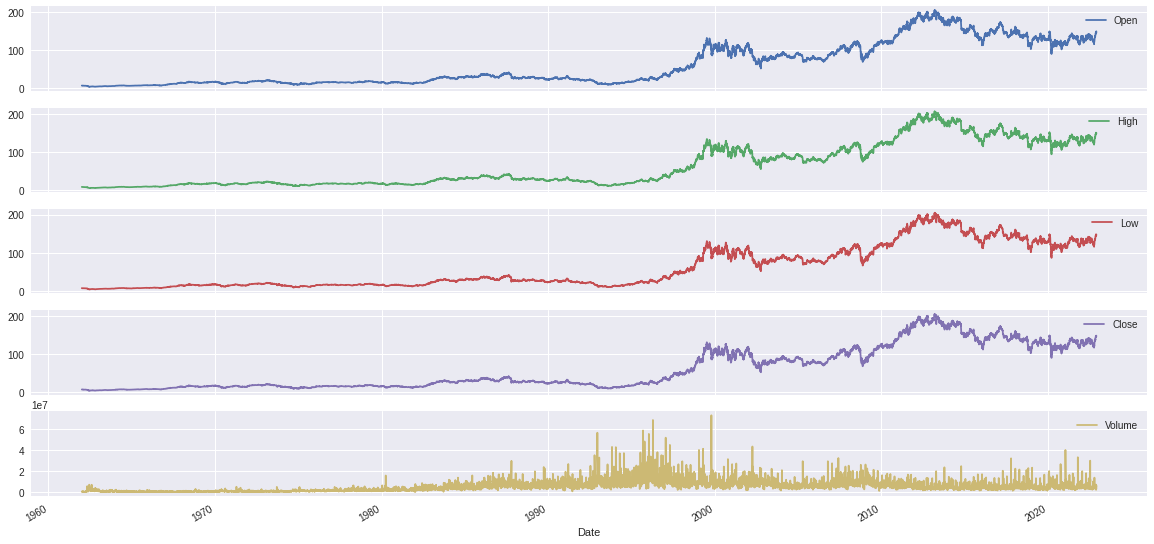

In [ ]:
df.plot(x='Date',subplots=True, figsize=(20,10))

In [ ]:
df.describe()

,Open,High,Low,Close,Volume
count,15336.000000,15336.000000,15336.000000,15336.000000,1.533600e+04
mean,60.514828,61.077888,59.981609,60.534317,5.099619e+06
std,55.469883,55.924530,55.047386,55.495327,4.639178e+06
min,3.900574,4.098152,3.824092,3.900574,0.000000e+00
25%,15.550311,15.654876,15.438277,15.546203,1.482313e+06
50%,28.770315,29.039198,28.561186,28.770315,4.326570e+06
75%,108.663960,110.095007,107.086519,108.776590,7.090547e+06
max,205.908218,206.405350,204.875717,206.309753,7.263915e+07


In [ ]:
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume
15331,2022-11-25,148.270004,149.490005,148.100006,148.369995,2075200
15332,2022-11-28,147.979996,148.240005,145.940002,146.179993,3538100
15333,2022-11-29,145.910004,147.169998,145.699997,146.490005,2754700
15334,2022-11-30,146.190002,149.639999,145.669998,148.899994,6377600
15335,2022-12-01,149.979996,150.009995,147.339996,149.160004,4494500


In [ ]:
df.reset_index(drop=True,inplace=True)
df

,Date,Open,High,Low,Close,Volume
0,1962-01-02,7.374124,7.374124,7.291268,7.291268,407940
1,1962-01-03,7.291268,7.355003,7.291268,7.355003,305955
2,1962-01-04,7.355003,7.355003,7.278521,7.281708,274575
3,1962-01-05,7.272148,7.272148,7.125558,7.138305,384405
4,1962-01-08,7.131931,7.131931,6.947100,7.004461,572685
...,...,...,...,...,...,...
15331,2022-11-25,148.270004,149.490005,148.100006,148.369995,2075200
15332,2022-11-28,147.979996,148.240005,145.940002,146.179993,3538100
15333,2022-11-29,145.910004,147.169998,145.699997,146.490005,2754700
15334,2022-11-30,146.190002,149.639999,145.669998,148.899994,6377600


In [ ]:
df.describe() # Volume changed the 0 min value

,Open,High,Low,Close,Volume
count,15336.000000,15336.000000,15336.000000,15336.000000,1.533600e+04
mean,60.514828,61.077888,59.981609,60.534317,5.099949e+06
std,55.469883,55.924530,55.047386,55.495327,4.638899e+06
min,3.900574,4.098152,3.824092,3.900574,2.353500e+04
25%,15.550311,15.654876,15.438277,15.546203,1.482705e+06
50%,28.770315,29.039198,28.561186,28.770315,4.326570e+06
75%,108.663960,110.095007,107.086519,108.776590,7.090547e+06
max,205.908218,206.405350,204.875717,206.309753,7.263915e+07


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d05dc11f0>,
      dtype=object)

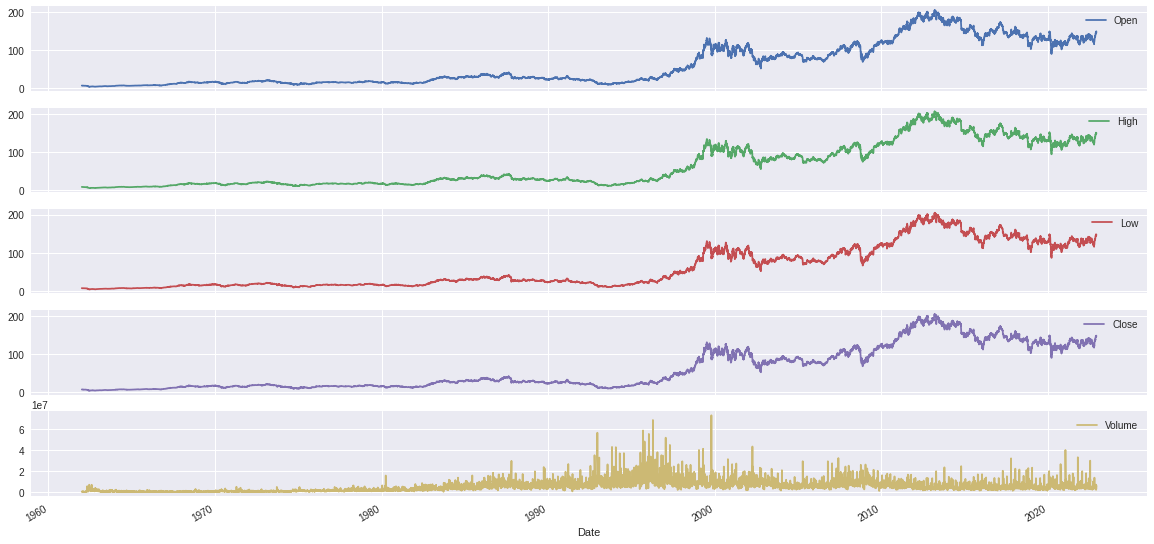

In [ ]:
df.plot(x='Date',subplots=True, figsize=(20,10))

## Modeling

In [ ]:
## Hyperparameters of TF 

batch_size = 32
seq_len = 128
d_k = 256 #256
d_v = 256 # 256
n_heads = 12
ff_dim = 256 #256

Normarilze & Train/Test Split

In [ ]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (12268, 5)
Validation data shape: (1534, 5)
Test data shape: (1533, 5)


,Open,High,Low,Close,Volume
1,0.564778,0.585893,0.592227,0.613582,0.029311
2,0.613582,0.592227,0.587957,0.567883,0.035499
3,0.564707,0.564707,0.540887,0.544117,0.056595
4,0.545124,0.545124,0.531045,0.546422,0.060364
5,0.559480,0.607510,0.623604,0.621125,0.035780


In [ ]:
df_train.describe()

,Open,High,Low,Close,Volume
count,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000
mean,0.593110,0.593042,0.593083,0.593124,0.043431
std,0.039262,0.034592,0.037298,0.039848,0.024260
min,0.230311,0.158737,0.000000,0.017685,0.000000
25%,0.572589,0.575717,0.575022,0.572166,0.030685
50%,0.592227,0.592227,0.592227,0.592227,0.039195
75%,0.612585,0.609280,0.610458,0.613039,0.050747
max,0.987990,0.974214,1.000000,0.913807,1.000000


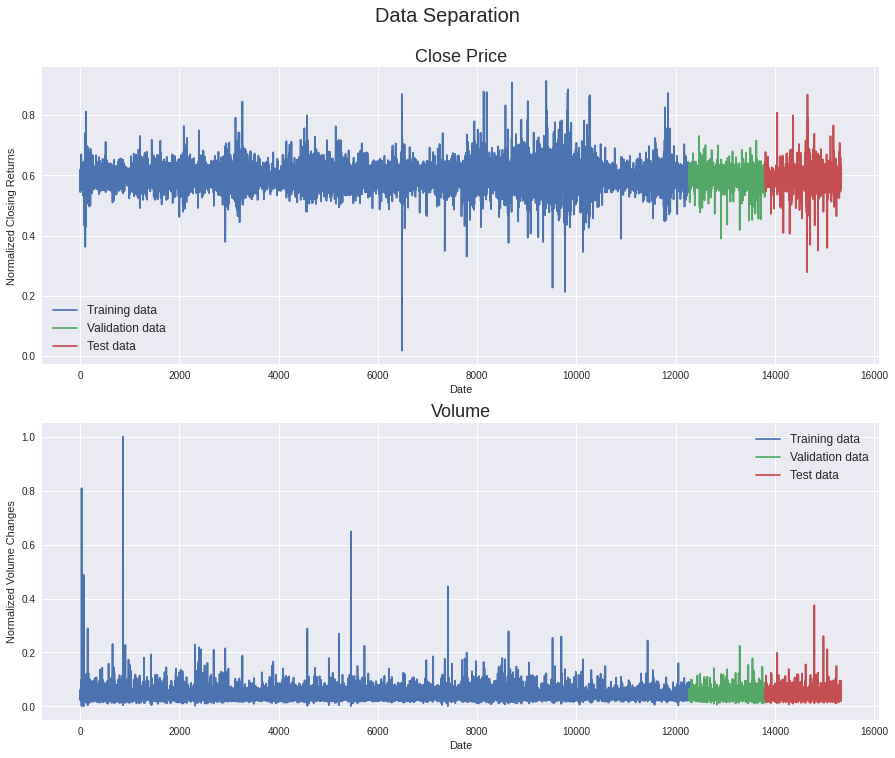

In [ ]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)



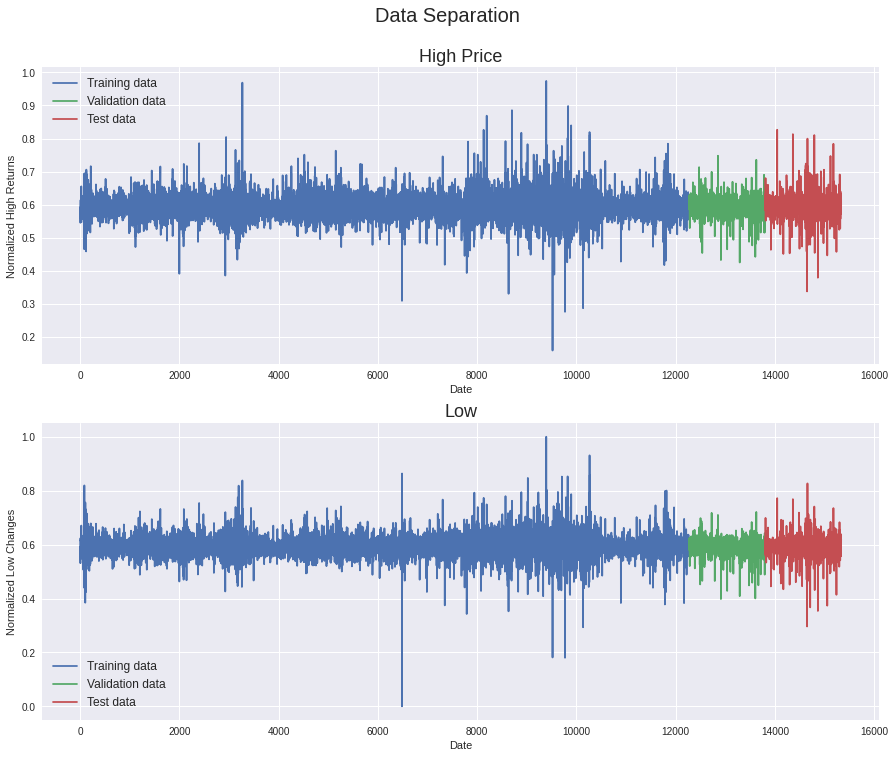

In [ ]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['High'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['High'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['High'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized High Returns')
ax1.set_title("High Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Low'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Low'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Low'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Low Changes')
ax2.set_title("Low", fontsize=18)
ax2.legend(loc="best", fontsize=12)

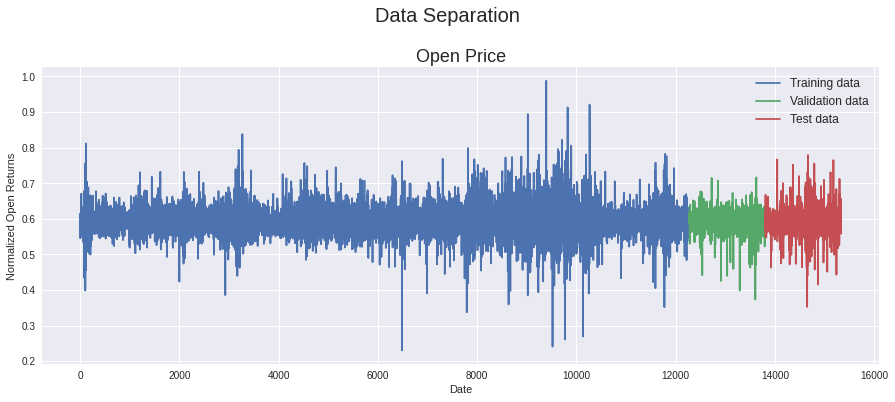

In [ ]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Open'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Open'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Open'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Open Returns')
ax1.set_title("Open Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

## Preprocessing data train

In [ ]:
df_train.describe()

,Open,High,Low,Close,Volume
count,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000
mean,0.593110,0.593042,0.593083,0.593124,0.043431
std,0.039262,0.034592,0.037298,0.039848,0.024260
min,0.230311,0.158737,0.000000,0.017685,0.000000
25%,0.572589,0.575717,0.575022,0.572166,0.030685
50%,0.592227,0.592227,0.592227,0.592227,0.039195
75%,0.612585,0.609280,0.610458,0.613039,0.050747
max,0.987990,0.974214,1.000000,0.913807,1.000000


In [ ]:
df_train.Low = df_train.where(df_train.Low >0 ,0.1).Low

In [ ]:
df_train.describe()

,Open,High,Low,Close,Volume
count,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000
mean,0.593110,0.593042,0.593091,0.593124,0.043431
std,0.039262,0.034592,0.037180,0.039848,0.024260
min,0.230311,0.158737,0.100000,0.017685,0.000000
25%,0.572589,0.575717,0.575022,0.572166,0.030685
50%,0.592227,0.592227,0.592227,0.592227,0.039195
75%,0.612585,0.609280,0.610458,0.613039,0.050747
max,0.987990,0.974214,1.000000,0.913807,1.000000


In [ ]:
df_train.Volume = df_train.where(df_train.Volume !=0 ,0.005).Volume

In [ ]:
df_train.describe()

,Open,High,Low,Close,Volume
count,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000
mean,0.593110,0.593042,0.593091,0.593124,0.043432
std,0.039262,0.034592,0.037180,0.039848,0.024260
min,0.230311,0.158737,0.100000,0.017685,0.000729
25%,0.572589,0.575717,0.575022,0.572166,0.030685
50%,0.592227,0.592227,0.592227,0.592227,0.039195
75%,0.612585,0.609280,0.610458,0.613039,0.050747
max,0.987990,0.974214,1.000000,0.913807,1.000000


## Training

In [ ]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (12140, 128, 5) (12140,)
Validation set shape (1406, 128, 5) (1406,)
Testing set shape (1405, 128, 5) (1405,)


## Time vector

In [ ]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model Training

In [ ]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model

# with tf.device('/device:GPU:0'):
model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=10, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 5)]     0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 128, 2)       512         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 7)       0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 128, 7)      99114       ['concatenate[0][0]',        

KeyboardInterrupt: ignored

4/4 [==============================] - 1s 221ms/step
 
Evaluation metrics
Training Data - Loss: 0.0019, MAE: 0.0281, MAPE: 199787.5625
Validation Data - Loss: 0.0012, MAE: 0.0264, MAPE: 7.2951
Test Data - Loss: 0.0064, MAE: 0.0542, MAPE: 17.9785


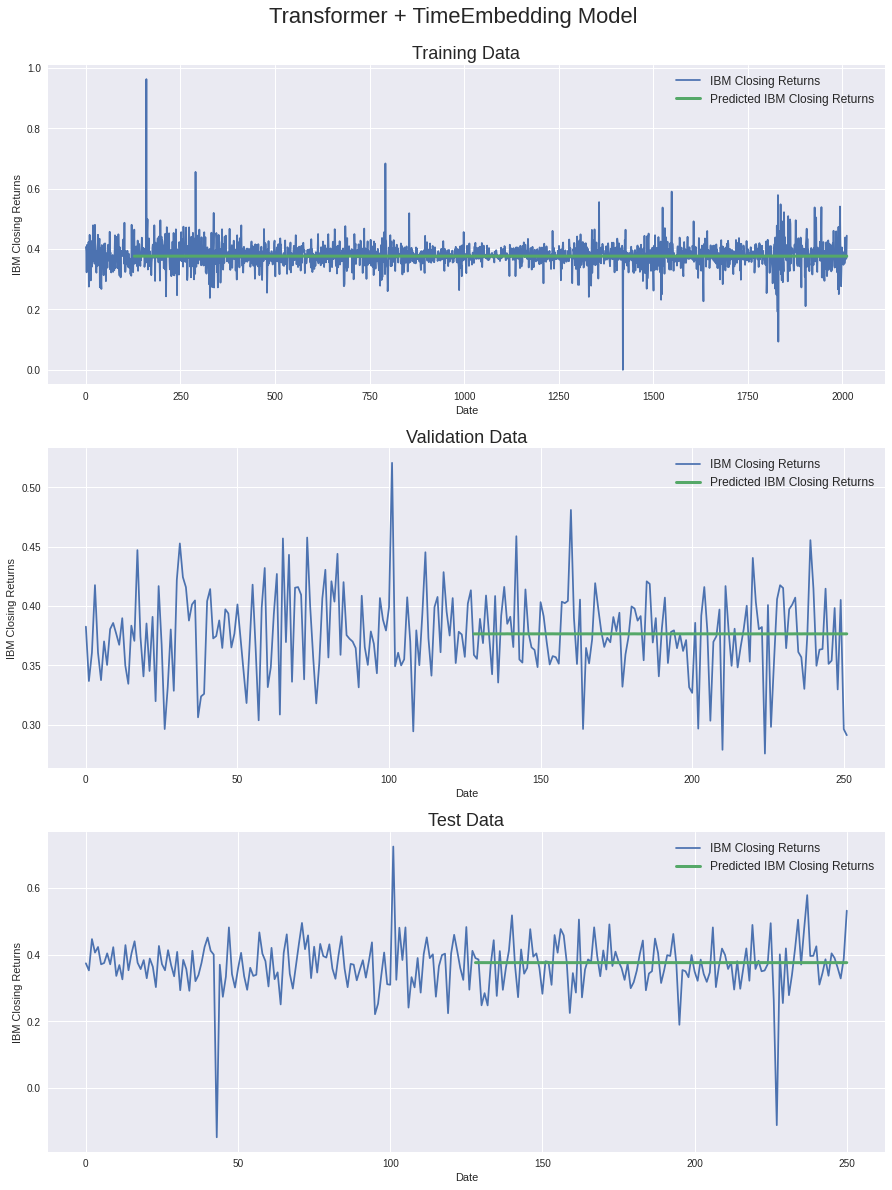

In [ ]:
model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

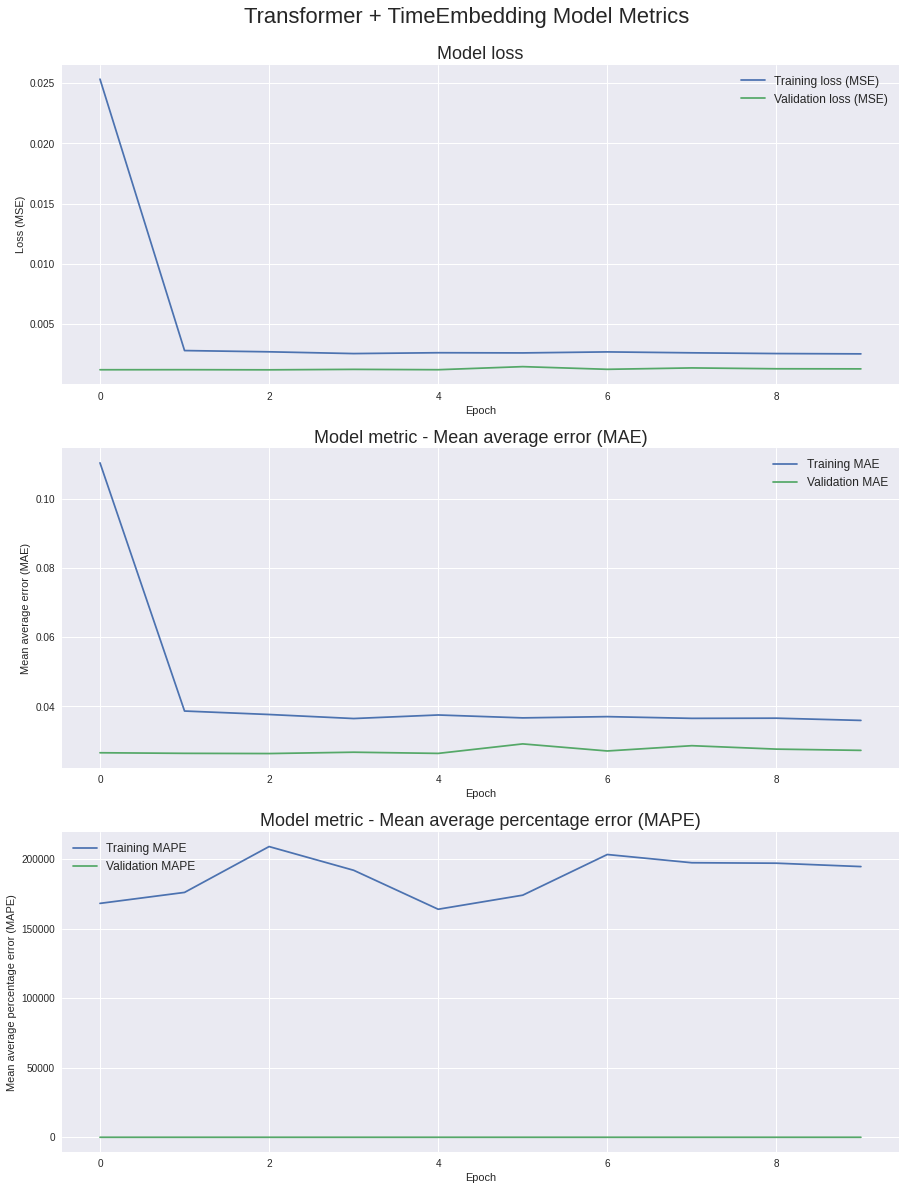

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)